In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import string 
import math
import nltk
import pickle
import os

from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

# Import pyLDAvis.gensim or pyLDAvis.gensim_models is dependent on the version of gensim you are using
# import pyLDAvis.gensim
import pyLDAvis.gensim_models

from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models.ldamodel import LdaModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models  
from pprint import pprint
from collections import Counter
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [3]:
# For converting mallet model to gensim for pyldavis to work

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [4]:
df = pd.read_csv("../../data/addedsw2_winemag-data-130k-v2-clean-desc-ngram-pos.csv")
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,variety,winery,ratings,ratings_label,cleaned_text,bigram_cleaned_review,trigram_cleaned_review,unigram_cleaned_review_noun_verbs_only,bigram_cleaned_review_noun_verbs_only,trigram_cleaned_review_noun_verbs_only
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,...,White Blend,Nicosia,good,2.0,aroma include tropical broom brimstone dried h...,aroma include tropical broom brimstone dried h...,aroma include tropical broom brimstone dried h...,aroma include broom brimstone dried offering a...,aroma include broom brimstone dried offering a...,aroma include broom brimstone dried offering a...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,...,Portuguese Red,Quinta dos Avidagos,good,2.0,ripe smooth still structured firm filled juicy...,ripe smooth still structured firm filled juicy...,ripe smooth still structured firm filled juicy...,ripe firm filled juicy berry fruit freshened a...,ripe firm filled juicy berry fruit freshened a...,ripe firm filled juicy berry fruit freshened a...
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,Pinot Gris,Rainstorm,good,2.0,tart snappy lime flesh rind dominate green pin...,tart snappy lime flesh_rind dominate green pin...,tart snappy lime flesh_rind dominate green pin...,tart lime rind dominate pineapple poke acidity...,tart lime flesh_rind dominate pineapple poke a...,tart lime flesh_rind dominate pineapple poke a...
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,...,Riesling,St. Julian,good,2.0,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange_blossom start...,pineapple rind lemon pith orange_blossom start...,pineapple rind lemon pith orange start aroma g...,pineapple rind lemon pith start aroma guava ma...,pineapple rind lemon pith start aroma guava ma...
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,Pinot Noir,Sweet Cheeks,good,2.0,much regular come across rather rough tannic r...,much regular come_across rather rough tannic r...,much regular come_across rather rough tannic r...,earthy think country companion hearty winter stew,come_across earthy think country companion hea...,come_across earthy think country companion hea...


In [11]:
full_records_cleaned_text_bigram = df['bigram_cleaned_review_noun_verbs_only'].values.tolist()

full_cleaned_bigram_text_list_split = [str(d).split() for d in full_records_cleaned_text_bigram]

dictionary_full_bigram = gensim.corpora.Dictionary(full_cleaned_bigram_text_list_split)

full_bigram_bow_corpus = [dictionary_full_bigram.doc2bow(doc) for doc in full_cleaned_bigram_text_list_split]

In [12]:
tfidf_bigram_model = models.TfidfModel(full_bigram_bow_corpus)
corpus_tfidf_bigram = tfidf_bigram_model[full_bigram_bow_corpus]

In [15]:
model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    ldamallet_tfidf_bigram_full_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf_bigram, num_topics=num_topics, id2word=dictionary_full_bigram)
    coherencemodel = CoherenceModel(ldamallet_tfidf_bigram_full_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(ldamallet_tfidf_bigram_full_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

#Topics: 2 Score: 0.5648831426362522
#Topics: 4 Score: 0.5554377998573486
#Topics: 6 Score: 0.5425044163348685
#Topics: 8 Score: 0.5586767547299928
#Topics: 10 Score: 0.571441320225364


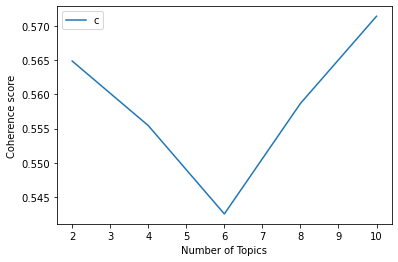

In [16]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# 6 Topics

In [17]:
topics6_ldamallet_tfidf_bigram_full_model = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_tfidf_bigram, num_topics=6, id2word=dictionary_full_bigram
)

In [19]:
coherencemodel_6 = CoherenceModel(topics6_ldamallet_tfidf_bigram_full_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
coherencemodel_6.get_coherence()

0.5647067403149824

In [14]:
# Visualize the topics - 6 topics
converted_topics6_ldamallet_tfidf_bigram_full_model = convertldaMalletToldaGen(topics6_ldamallet_tfidf_bigram_full_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_topics6_ldamallet_tfidf_bigram_full_model, full_bigram_bow_corpus, dictionary_full_bigram)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.000057 -0.000507       1        1  17.257992
5      0.000686  0.000476       2        1  17.073008
3     -0.000808  0.000357       3        1  16.691593
4      0.000031 -0.000167       4        1  16.564903
0      0.000007 -0.000013       5        1  16.294687
2      0.000028 -0.000144       6        1  16.117819, topic_info=            Term        Freq       Total Category  logprob  loglift
6610         nan  375.000000  375.000000  Default  30.0000  30.0000
0        acidity  250.000000  250.000000  Default  29.0000  29.0000
11         berry  187.000000  187.000000  Default  28.0000  28.0000
2          aroma  190.000000  190.000000  Default  27.0000  27.0000
88    aftertaste  190.000000  190.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8068      négoce   10.096338   62.608902   Topic6 -10.0945   0.0005
8051         sam   10.096338   62.608902   Topic6 -10.0945   0.0005
8049      billed   10.096338   62.608902   Topic6 -10.0945   0.0005
8038   dwindling   10.096338   62.608902   Topic6 -10.0945   0.0005
8029       breed   10.096338   62.608902   Topic6 -10.0945   0.0005

[332 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.043906  acidity
0         2  0.043906  acidity
0         3  0.790315  acidity
0         4  0.039915  acidity
0         5  0.039915  acidity
...     ...       ...      ...
8056      2  0.175694    zippy
8056      3  0.159722    zippy
8056      4  0.159722    zippy
8056      5  0.159722    zippy
8056      6  0.159722    zippy

[588 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 5, 1, 3])

# 5 Topics

In [19]:
topics5_ldamallet_tfidf_bigram_full_model = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_tfidf_bigram, num_topics=5, id2word=dictionary_full_bigram
)

In [21]:
coherencemodel_5 = CoherenceModel(topics5_ldamallet_tfidf_bigram_full_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
coherencemodel_5.get_coherence()

0.5546221949370246

In [25]:
converted_topics5_ldamallet_tfidf_bigram_full_model = convertldaMalletToldaGen(topics5_ldamallet_tfidf_bigram_full_model)

In [23]:
# Visualize the topics - 5 topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_topics5_ldamallet_tfidf_bigram_full_model, full_bigram_bow_corpus, dictionary_full_bigram)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.000584  0.000202       1        1  20.649666
0      0.000106 -0.000426       2        1  20.175640
3      0.000083 -0.000238       3        1  20.034077
1      0.000393  0.000465       4        1  19.798990
2      0.000002 -0.000003       5        1  19.341629, topic_info=                   Term        Freq       Total Category  logprob  loglift
6610                nan  372.000000  372.000000  Default  30.0000  30.0000
0               acidity  252.000000  252.000000  Default  29.0000  29.0000
2                 aroma  187.000000  187.000000  Default  28.0000  28.0000
88           aftertaste  187.000000  187.000000  Default  27.0000  27.0000
11                berry  191.000000  191.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
8047          permeates   12.123271   62.606544   Topic5 -10.0939   0.0012
8048              actor   12.123271   62.606544   Topic5 -10.0939   0.0012
8036  assertive_refined   12.123271   62.606544   Topic5 -10.0939   0.0012
8027           casualty   12.123271   62.606544   Topic5 -10.0939   0.0012
8028     whiff_barnyard   12.123271   62.606544   Topic5 -10.0939   0.0012

[278 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.051583  acidity
0         2  0.801514  acidity
0         3  0.051583  acidity
0         4  0.047615  acidity
0         5  0.047615  acidity
...     ...       ...      ...
8056      1  0.207646    zippy
8056      2  0.207646    zippy
8056      3  0.207646    zippy
8056      4  0.191673    zippy
8056      5  0.191673    zippy

[460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

# 4 Topics

In [20]:
topics4_ldamallet_tfidf_bigram_full_model = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_tfidf_bigram, num_topics=4, id2word=dictionary_full_bigram
)

In [25]:
coherencemodel_4 = CoherenceModel(topics4_ldamallet_tfidf_bigram_full_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
coherencemodel_4.get_coherence()

0.5721904977609351

In [26]:
converted_topics4_ldamallet_tfidf_bigram_full_model = convertldaMalletToldaGen(topics4_ldamallet_tfidf_bigram_full_model)

In [26]:
# Visualize the topics - 4 topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_topics4_ldamallet_tfidf_bigram_full_model, full_bigram_bow_corpus, dictionary_full_bigram)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.000700 -0.000060       1        1  25.735119
2     -0.000142  0.000091       2        1  24.997477
3     -0.000348 -0.000352       3        1  24.919043
0     -0.000210  0.000320       4        1  24.348356, topic_info=              Term        Freq       Total Category  logprob  loglift
6610           nan  384.000000  384.000000  Default  30.0000  30.0000
0          acidity  250.000000  250.000000  Default  29.0000  29.0000
88      aftertaste  187.000000  187.000000  Default  28.0000  28.0000
11           berry  187.000000  187.000000  Default  27.0000  27.0000
2            aroma  191.000000  191.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
8055  distribution   15.249023   62.607166   Topic4 -10.0947   0.0003
8066    bacigalupi   15.249023   62.607166   Topic4 -10.0947   0.0003
8067           bob   15.249023   62.607166   Topic4 -10.0947   0.0003
8065     mustiness   15.249023   62.607166   Topic4 -10.0947   0.0003
8054       coussin   15.249023   62.607166   Topic4 -10.0947   0.0003

[218 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          1  0.063847     acidity
0          2  0.814052     acidity
0          3  0.063847     acidity
0          4  0.059857     acidity
8037       1  0.255562     acreage
...      ...       ...         ...
24173      4  0.239589  zabaglione
8056       1  0.255562       zippy
8056       2  0.255562       zippy
8056       3  0.255562       zippy
8056       4  0.239589       zippy

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

## 3 Topics

In [27]:
topics3_ldamallet_tfidf_bigram_full_model = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_tfidf_bigram, num_topics=3, id2word=dictionary_full_bigram
)

In [28]:
coherencemodel_3 = CoherenceModel(topics3_ldamallet_tfidf_bigram_full_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
coherencemodel_3.get_coherence()

0.5150861679853507

In [29]:
# Visualize the topics - 3 topics
converted_topics3_ldamallet_tfidf_bigram_full_model = convertldaMalletToldaGen(topics3_ldamallet_tfidf_bigram_full_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(converted_topics3_ldamallet_tfidf_bigram_full_model, full_bigram_bow_corpus, dictionary_full_bigram)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.000426 -0.000093       1        1  33.775242
1     -0.000313 -0.000251       2        1  33.337036
0     -0.000113  0.000344       3        1  32.887726, topic_info=                     Term       Freq       Total Category  logprob  loglift
6610                  nan  375.00000  375.000000  Default  30.0000  30.0000
88             aftertaste  186.00000  186.000000  Default  29.0000  29.0000
2                   aroma  187.00000  187.000000  Default  28.0000  28.0000
11                  berry  189.00000  189.000000  Default  27.0000  27.0000
0                 acidity  252.00000  252.000000  Default  26.0000  26.0000
...                   ...        ...         ...      ...      ...      ...
8067                  bob   20.59897   62.602905   Topic3 -10.0945   0.0005
8069        michael_david   20.59897   62.602905   Topic3 -10.0945   0.0005
8070             minority   20.59897   62.602905   Topic3 -10.0945   0.0005
8055         distribution   20.59897   62.602905   Topic3 -10.0945   0.0005
8052  fermented_stainless   20.59897   62.602905   Topic3 -10.0945   0.0005

[168 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          1  0.587282     acidity
0          2  0.329354     acidity
0          3  0.083330     acidity
88         1  0.112784  aftertaste
88         2  0.112784  aftertaste
...      ...       ...         ...
24173      2  0.335448  zabaglione
24173      3  0.335448  zabaglione
8056       1  0.335448       zippy
8056       2  0.335448       zippy
8056       3  0.335448       zippy

[258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

# 2 Topics

In [13]:
topics2_ldamallet_tfidf_bigram_full_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf_bigram, num_topics=2, id2word=dictionary_full_bigram)

coherencemodel_2 = CoherenceModel(topics2_ldamallet_tfidf_bigram_full_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
coherencemodel_2.get_coherence()

0.48276935957032063

In [17]:
# Visualize the topics - 3 topics
converted_topics2_ldamallet_tfidf_bigram_full_model = convertldaMalletToldaGen(topics2_ldamallet_tfidf_bigram_full_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(converted_topics2_ldamallet_tfidf_bigram_full_model, full_bigram_bow_corpus, dictionary_full_bigram)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.000305  0.0       1        1  50.317637
0     -0.000305  0.0       2        1  49.682363, topic_info=            Term        Freq       Total Category  logprob  loglift
6610         nan  377.000000  377.000000  Default  30.0000  30.0000
0        acidity  249.000000  249.000000  Default  29.0000  29.0000
88    aftertaste  187.000000  187.000000  Default  28.0000  28.0000
2          aroma  188.000000  188.000000  Default  27.0000  27.0000
11         berry  188.000000  188.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
18      dominate   31.114755   62.606556   Topic2 -10.0947   0.0003
19     fermented   31.114755   62.606556   Topic2 -10.0947   0.0003
2          aroma   31.114755  188.573764   Topic2 -10.0947  -1.1023
11         berry   31.114755  188.573764   Topic2 -10.0947  -1.1023
13          firm   31.114755  125.590160   Topic2 -10.0947  -0.6958

[95 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.124351     acidity
0         2  0.874466     acidity
88        1  0.165717  aftertaste
88        2  0.833932  aftertaste
1         1  0.495156       apple
...     ...       ...         ...
54        2  0.744977       spicy
501       1  0.248326       taste
501       2  0.744977       taste
1108      1  0.748466     tasting
1108      2  0.246835     tasting

[104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## Save Models

In [27]:
# save 5 topics model to disk
with open("converted_topics5_ldamallet_tfidf_bigram_full_model.pk", "wb") as file:
   pickle.dump(converted_topics5_ldamallet_tfidf_bigram_full_model, file)

for idx, topic in converted_topics5_ldamallet_tfidf_bigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

Topic: 1
Word: 0.000*"bitterness" + 0.000*"firm" + 0.000*"tasting" + 0.000*"crisp" + 0.000*"fat" + 0.000*"fruit" + 0.000*"soften" + 0.000*"dark" + 0.000*"supplemented" + 0.000*"piecrust"

Topic: 2
Word: 0.000*"aftertaste" + 0.000*"lack_definition" + 0.000*"blackberry" + 0.000*"butterscotch" + 0.000*"extraction" + 0.000*"chalky" + 0.000*"party" + 0.000*"simple" + 0.000*"lion" + 0.000*"citrus"

Topic: 3
Word: 0.000*"overripe_raisin" + 0.000*"medium_body" + 0.000*"taste" + 0.000*"dense" + 0.000*"spicy" + 0.000*"pruny" + 0.000*"kobrand" + 0.000*"piecrust" + 0.000*"cabochon" + 0.000*"boedecker"

Topic: 4
Word: 0.001*"nan" + 0.001*"acidity" + 0.000*"aroma" + 0.000*"candied" + 0.000*"battling" + 0.000*"edge" + 0.000*"supplemented" + 0.000*"boedecker" + 0.000*"terrassen" + 0.000*"flimsy"

Topic: 5
Word: 0.000*"berry" + 0.000*"ripe" + 0.000*"plummy" + 0.000*"chunky" + 0.000*"developing" + 0.000*"candy" + 0.000*"juiciness" + 0.000*"cherry" + 0.000*"boedecker" + 0.000*"terrassen"



In [28]:
# save 4 topics model to disk
with open("converted_topics4_ldamallet_tfidf_bigram_full_model.pk", "wb") as file:
   pickle.dump(converted_topics4_ldamallet_tfidf_bigram_full_model, file)

for idx, topic in converted_topics4_ldamallet_tfidf_bigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

Topic: 1
Word: 0.001*"nan" + 0.000*"fruit" + 0.000*"juiciness" + 0.000*"lion" + 0.000*"overripe_raisin" + 0.000*"taste" + 0.000*"fat" + 0.000*"cabochon" + 0.000*"boedecker" + 0.000*"terrassen"

Topic: 2
Word: 0.000*"berry" + 0.000*"dense" + 0.000*"firm" + 0.000*"bitterness" + 0.000*"candy" + 0.000*"blackberry" + 0.000*"tasting" + 0.000*"crisp" + 0.000*"chalky" + 0.000*"extraction"

Topic: 3
Word: 0.001*"acidity" + 0.000*"aroma" + 0.000*"dark" + 0.000*"plummy" + 0.000*"ripe" + 0.000*"chunky" + 0.000*"party" + 0.000*"pruny" + 0.000*"lack_definition" + 0.000*"piecrust"

Topic: 4
Word: 0.000*"aftertaste" + 0.000*"butterscotch" + 0.000*"kobrand" + 0.000*"soften" + 0.000*"battling" + 0.000*"developing" + 0.000*"medium_body" + 0.000*"candied" + 0.000*"spicy" + 0.000*"seize"



In [32]:
# save 3 topics model to disk
with open("converted_topics3_ldamallet_tfidf_bigram_full_model.pk", "wb") as file:
   pickle.dump(converted_topics3_ldamallet_tfidf_bigram_full_model, file)

for idx, topic in converted_topics3_ldamallet_tfidf_bigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

Topic: 1
Word: 0.000*"aftertaste" + 0.000*"chunky" + 0.000*"crisp" + 0.000*"pruny" + 0.000*"kobrand" + 0.000*"tasting" + 0.000*"dense" + 0.000*"ripe" + 0.000*"dark" + 0.000*"candied"

Topic: 2
Word: 0.001*"nan" + 0.000*"aroma" + 0.000*"spicy" + 0.000*"party" + 0.000*"edge" + 0.000*"taste" + 0.000*"fruit" + 0.000*"simple" + 0.000*"lack_definition" + 0.000*"acidity"

Topic: 3
Word: 0.000*"berry" + 0.000*"acidity" + 0.000*"overripe_raisin" + 0.000*"chalky" + 0.000*"extraction" + 0.000*"battling" + 0.000*"butterscotch" + 0.000*"soften" + 0.000*"medium_body" + 0.000*"plummy"



In [18]:
# save 2 topics model to disk
# with open("converted_topics2_ldamallet_tfidf_bigram_full_model.pk", "wb") as file:
#    pickle.dump(converted_topics2_ldamallet_tfidf_bigram_full_model, file)

for idx, topic in converted_topics2_ldamallet_tfidf_bigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

Topic: 1
Word: 0.000*"acidity" + 0.000*"aftertaste" + 0.000*"chalky" + 0.000*"overripe_raisin" + 0.000*"dense" + 0.000*"medium_body" + 0.000*"fat" + 0.000*"dark" + 0.000*"butterscotch" + 0.000*"taste"

Topic: 2
Word: 0.000*"nan" + 0.000*"aroma" + 0.000*"berry" + 0.000*"extraction" + 0.000*"tasting" + 0.000*"cherry" + 0.000*"crisp" + 0.000*"juiciness" + 0.000*"pruny" + 0.000*"blackberry"

